# **df4 - Model Training**

**Used to train machine translation models for multilingual document translation.**

# **Let’s fine-tune the mBART and mT5 models on policy text dataset!**

**We’ll train them for a text summarization task — using the multilingual policy text (Policy_Text_EN, Policy_Text_FR, Policy_Text_ES) as input and the AI-generated Summarized_Text as the target.**

In [ ]:
!pip install transformers datasets sentencepiece accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# **2. Load Data & Preprocess**

In [2]:
import pandas as pd
from datasets import Dataset

# Load your aligned dataset
df = pd.read_csv('/content/synthetic_policy_dataset.csv')

# Keep only needed columns
df = df[['Policy_Text_EN', 'Summarized_Text']]

# Convert to Hugging Face Dataset format
dataset = Dataset.from_pandas(df)


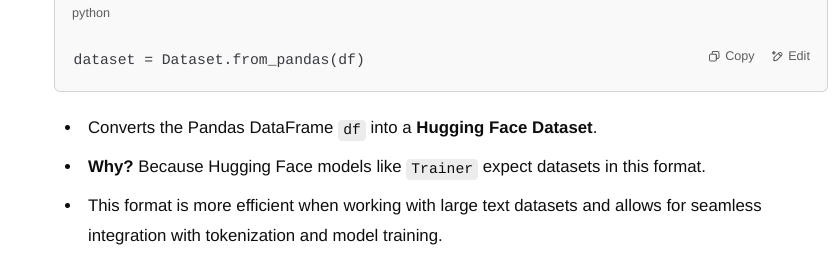

In [ ]:
dataset

Dataset({
    features: ['Policy_Text_EN', 'Summarized_Text'],
    num_rows: 1000
})

In [5]:
df.head()

Policy_Text_EN  \
0  Business insurance protects against liability ...   
1  Business insurance protects against liability ...   
2      Vehicle insurance covers theft and vandalism.   
3  Travel insurance covers trip cancellations and...   
4      Vehicle insurance covers theft and vandalism.   

                         Summarized_Text  
0  Protects home from natural disasters.  
1        Covers vehicle accident damage.  
2          Covers hospitalization costs.  
3       Includes fire damage protection.  
4        Covers vehicle accident damage.

# **3. Tokenizer Setup (for mBART)**

In [6]:
from transformers import MBartTokenizer

model_name = "facebook/mbart-large-50"
tokenizer = MBartTokenizer.from_pretrained(model_name)

# Tokenize the dataset
def preprocess_function(examples):
    model_inputs = tokenizer(examples['Policy_Text_EN'], max_length=512, truncation=True)
    labels = tokenizer(examples['Summarized_Text'], max_length=128, truncation=True)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

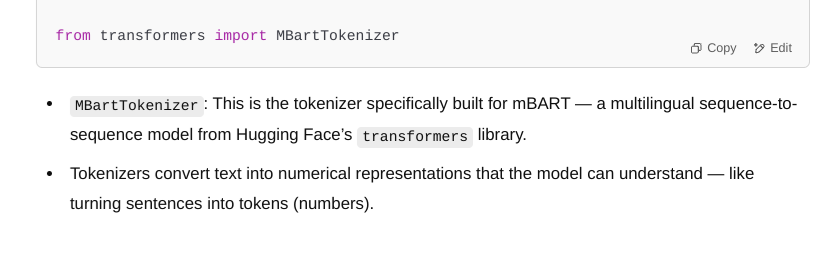

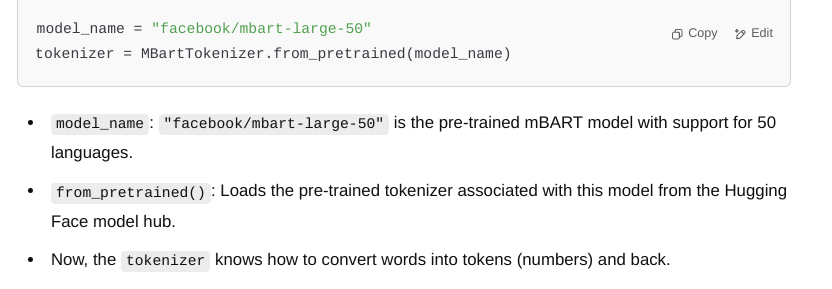

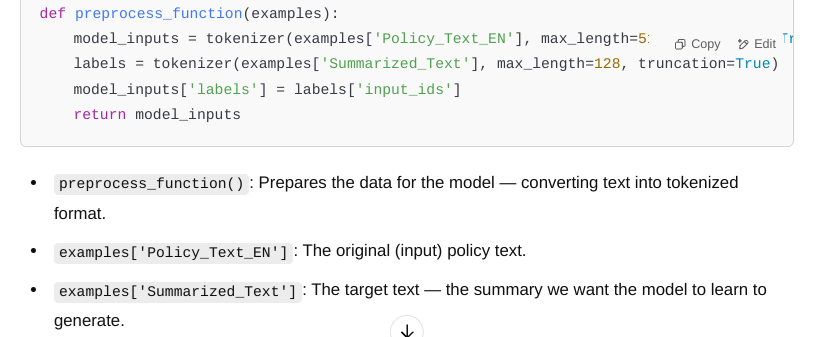

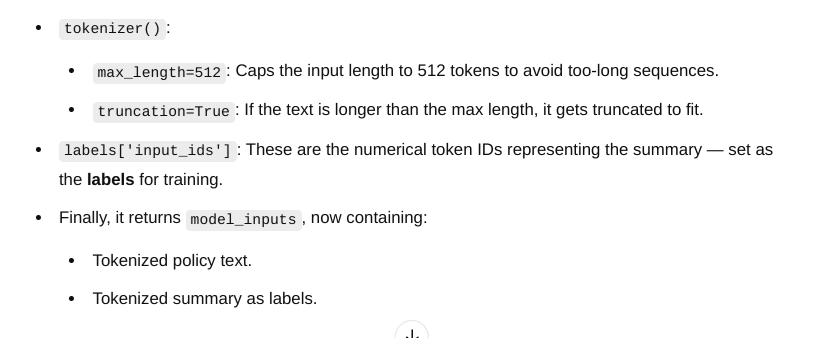

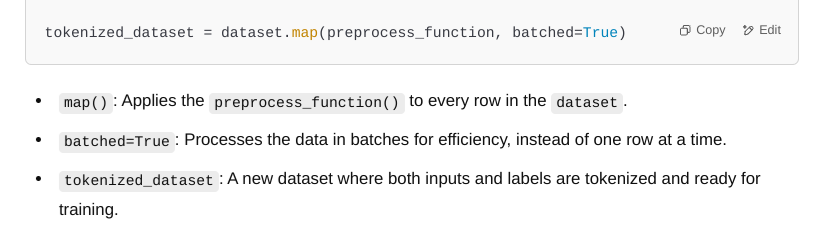

# So essentially, this whole process turns your text into a format the mBART model can use — input IDs and target IDs — so it can learn the mapping from policy text to summarized text

# **4. Model & Training Setup (mBART)**

In [7]:
import pandas as pd
import torch
import gc
from transformers import MBartForConditionalGeneration, MBartTokenizer, TrainingArguments, Trainer
from datasets import Dataset

# Clear memory
gc.collect()
torch.cuda.empty_cache()

# Load and sample dataset
cols_needed = ['Policy_Text_EN', 'Summarized_Text']
df = pd.read_csv('/content/synthetic_policy_dataset.csv', usecols=cols_needed)
df = df.sample(frac=0.03).reset_index(drop=True)  # Start with 3% of the data

# Convert to Hugging Face Dataset
small_dataset = Dataset.from_dict({
    'Policy_Text_EN': df['Policy_Text_EN'].tolist(),
    'Summarized_Text': df['Summarized_Text'].tolist()
})

# Load tokenizer and model
model_name = 'facebook/mbart-large-50'
tokenizer = MBartTokenizer.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name)
model.gradient_checkpointing_enable()

# Tokenization function
def preprocess_function(examples):
    inputs = tokenizer(examples['Policy_Text_EN'], padding='max_length', truncation=True, max_length=128)
    targets = tokenizer(examples['Summarized_Text'], padding='max_length', truncation=True, max_length=32)
    inputs['labels'] = targets['input_ids']
    return inputs

# Tokenize and format dataset
small_tokenized_dataset = small_dataset.map(preprocess_function, batched=True)
small_tokenized_dataset = small_tokenized_dataset.with_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./mbart-finetuned',
    evaluation_strategy='no',
    save_strategy='no',
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=32,  # Higher steps to simulate larger batch
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    fp16=True,
    report_to='none',
    dataloader_num_workers=0,  # Avoid multiprocessing
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_tokenized_dataset,
    tokenizer=tokenizer
)

# Train
try:
    trainer.train()
except RuntimeError as e:
    print(f"Runtime error: {e}")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'MBart50Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-07d80d70cb0c>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

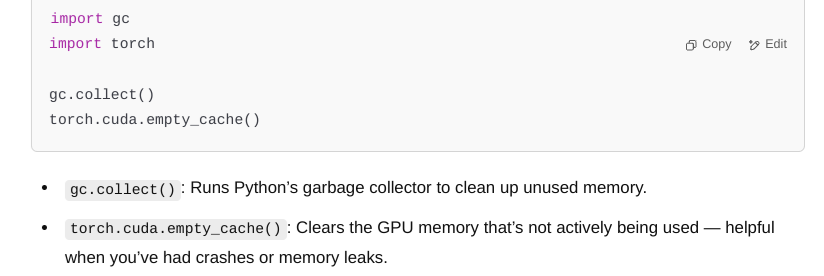

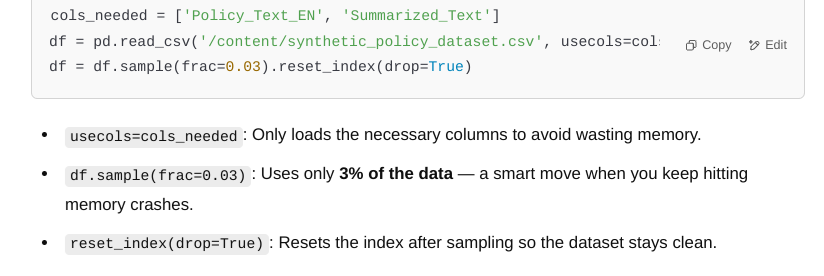

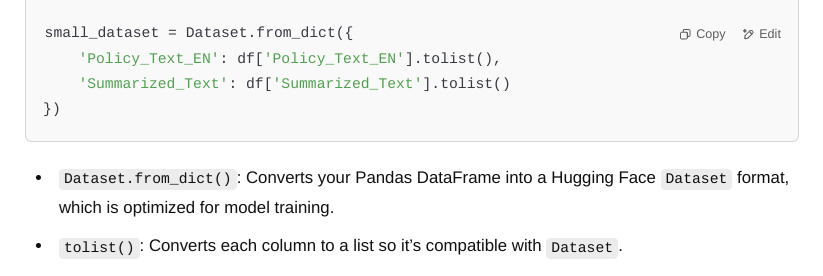

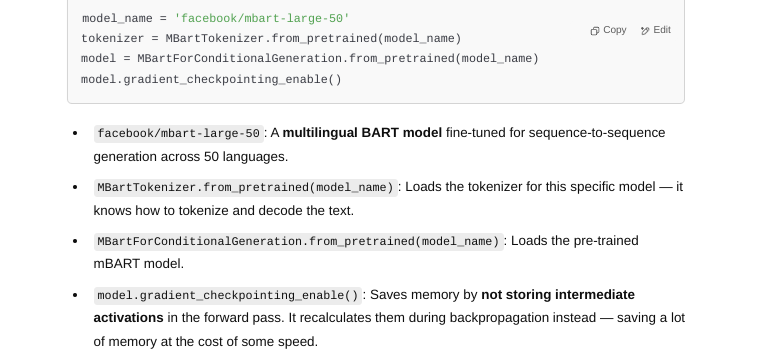

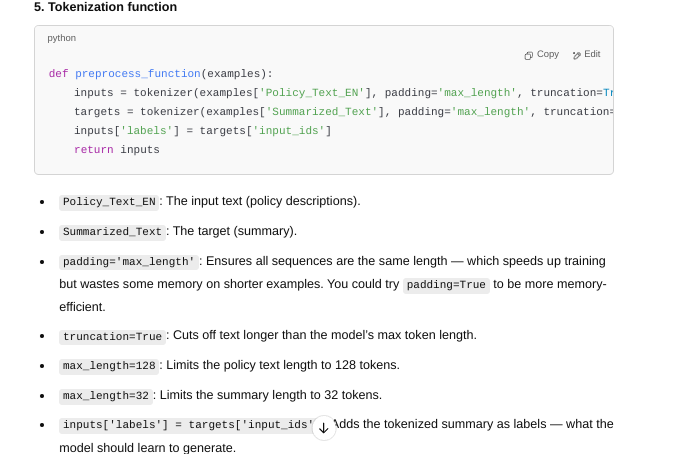

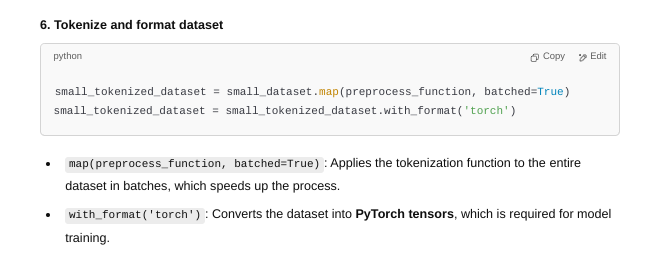

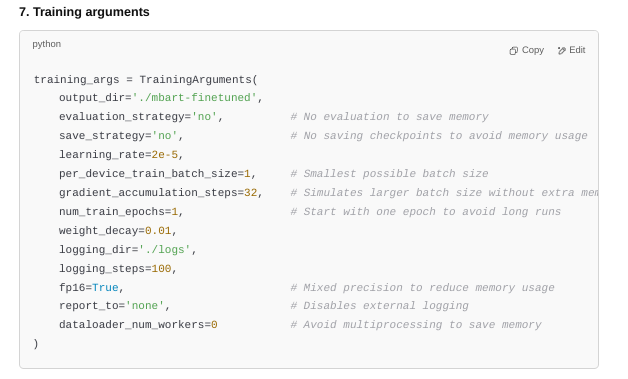

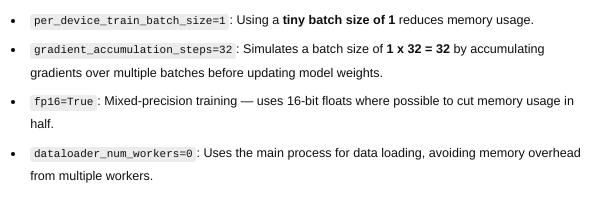

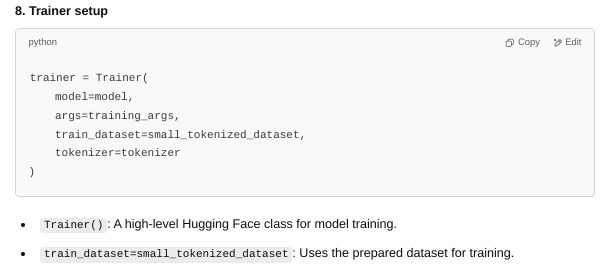

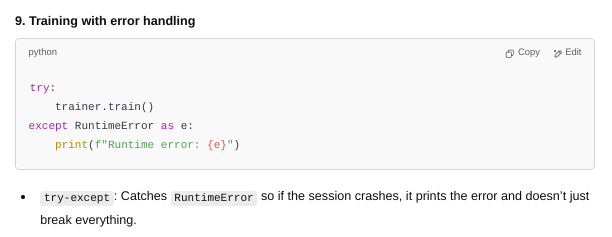

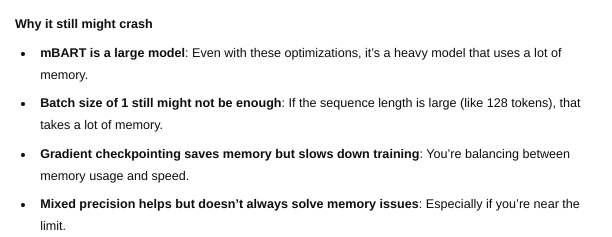

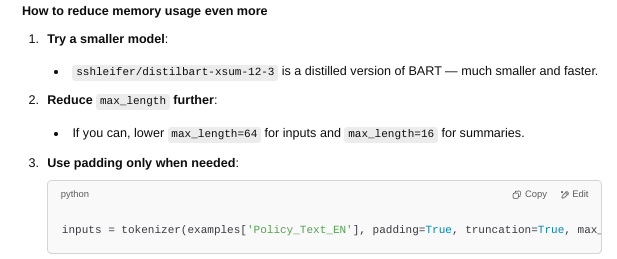

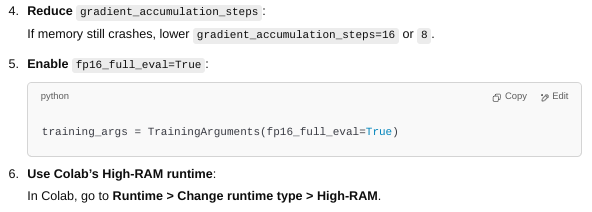

# **5. (Optional) Fine-tune mT5**

In [8]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "google/mt5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Preprocess and train similarly, replacing model/tokenizer


tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# switching from mBART to mT5, which is a great move because mT5 is also a powerful multilingual text-to-text model. Here’s what this code does step by step

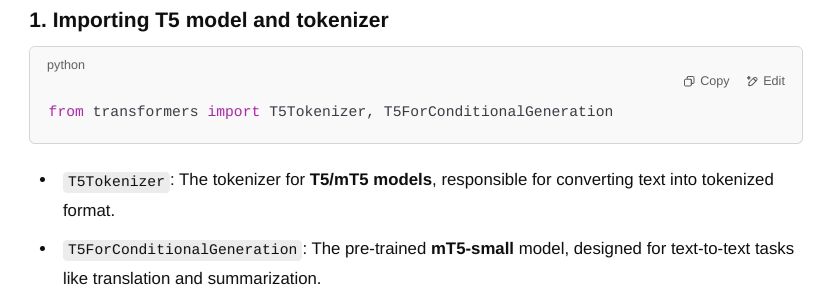

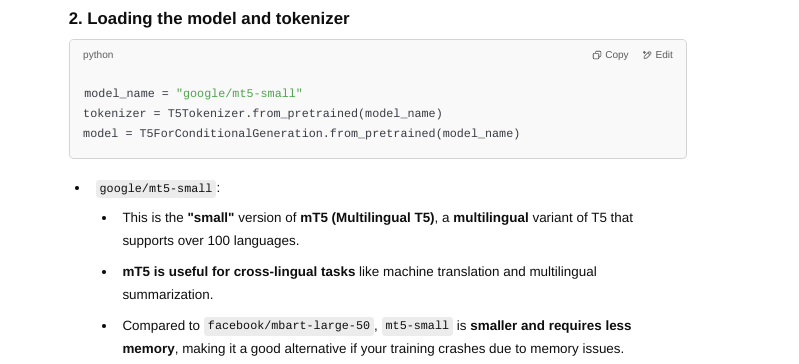

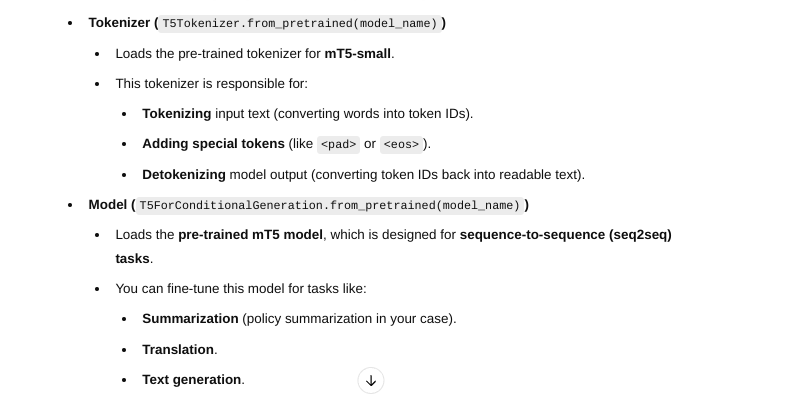

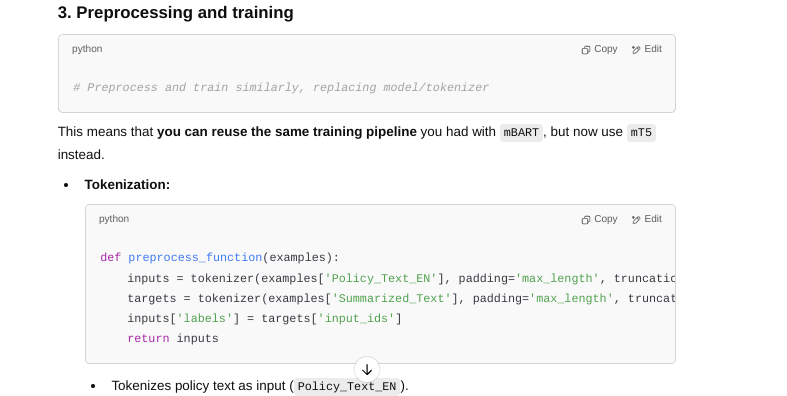

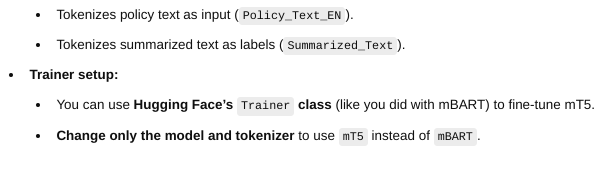

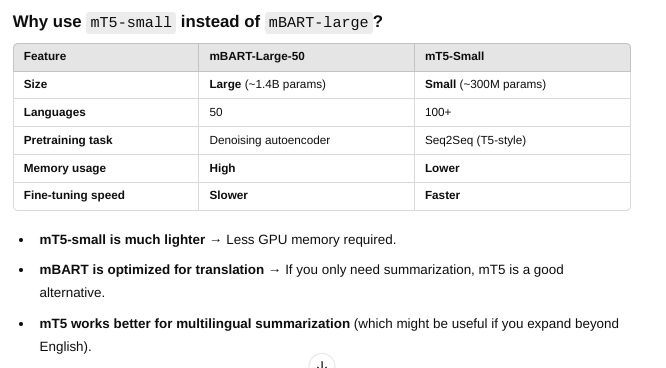

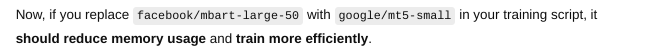

# **6. Save the Model**


In [9]:
model.save_pretrained("./mbart-finetuned")
tokenizer.save_pretrained("./mbart-finetuned")

('./mbart-finetuned/tokenizer_config.json',
 './mbart-finetuned/special_tokens_map.json',
 './mbart-finetuned/spiece.model',
 './mbart-finetuned/added_tokens.json')

In [ ]:
# Save the fine-tuned mT5 model and tokenizer
model.save_pretrained("./mt5-finetuned")
tokenizer.save_pretrained("./mt5-finetuned")

# **Prediction**

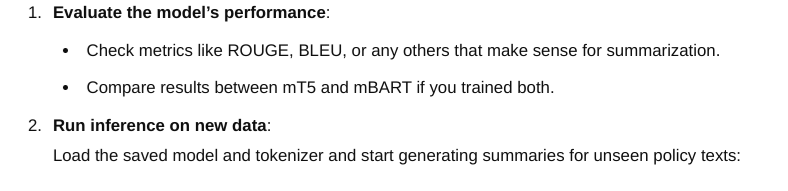

In [ ]:
!ls ./mbart-finetuned

In [ ]:
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# from transformers import MBartForConditionalGeneration, MBartTokenizer

# model_path = "./mbart-finetuned"
# model = MBartForConditionalGeneration.from_pretrained(model_path)
# tokenizer = MBartTokenizer.from_pretrained(model_path)

# # Example input
# text = "This policy covers damage to your vehicle caused by accidents"
# inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True)

# # Generate summary
# outputs = model.generate(**inputs, max_length=128, num_beams=4, early_stopping=True)
# summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
# print(summary)


# **mBART Very High Memory so Used as mT5**

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_path = "./mt5-finetuned"  # Change this to your mT5 save path

# Load the saved model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Example inference
text = "This policy covers damage to your vehicle caused by accidents"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Generate summary
output = model.generate(**inputs)
summary = tokenizer.decode(output[0], skip_special_tokens=True)

print(summary)

In [ ]:
!ls ./mt5-finetuned

In [ ]:
text = "This policy covers damage to your vehicle caused by accidents"
inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

In [ ]:
output = model.generate(
    **inputs,
    max_length=128,
    num_beams=5,           # Beam search for better quality
    early_stopping=True,   # Stop when a complete sentence is formed
    no_repeat_ngram_size=2 # Avoid repeating phrases
)

summary = tokenizer.decode(output[0], skip_special_tokens=True)
print(summary)

# **Check Weight added or not**

In [ ]:
import torch

# Check the original model
original_model = T5ForConditionalGeneration.from_pretrained("google/mt5-small")
original_weights = original_model.state_dict()

# Check the fine-tuned model
finetuned_weights = model.state_dict()

# Compare a few layers to see if they changed
for name, param in original_weights.items():
    if not torch.equal(param, finetuned_weights[name]):
        print(f"Weights changed for: {name}")
        break
else:
    print("No weights were updated — model may not have been fine-tuned properly.")

# **Weight not updated so again tune Model**

In [ ]:
import pandas as pd
import torch
import gc
from transformers import T5ForConditionalGeneration, T5Tokenizer, TrainingArguments, Trainer
from datasets import Dataset

# Clear memory
gc.collect()
torch.cuda.empty_cache()

# Load and sample dataset
cols_needed = ['Policy_Text_EN', 'Summarized_Text']
df = pd.read_csv('/content/synthetic_policy_dataset.csv', usecols=cols_needed)
df['Policy_Text_EN'] = "summarize: " + df['Policy_Text_EN']  # Add task prefix
df = df.sample(frac=0.03).reset_index(drop=True)

# Convert to Hugging Face Dataset
small_dataset = Dataset.from_dict({
    'Policy_Text_EN': df['Policy_Text_EN'].tolist(),
    'Summarized_Text': df['Summarized_Text'].tolist()
})

# Load tokenizer and model
model_name = 'google/mt5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tokenization function
def preprocess_function(examples):
    inputs = tokenizer(examples['Policy_Text_EN'], padding='max_length', truncation=True, max_length=512)
    targets = tokenizer(examples['Summarized_Text'], padding='max_length', truncation=True, max_length=128)
    inputs['labels'] = targets['input_ids']
    return inputs

# Tokenize and format dataset
small_tokenized_dataset = small_dataset.map(preprocess_function, batched=True)
small_tokenized_dataset = small_tokenized_dataset.with_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./mt5-finetuned',
    evaluation_strategy='no',
    save_strategy='steps',
    save_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    fp16=True,
    report_to='none',
    dataloader_num_workers=0,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_tokenized_dataset,
    tokenizer=tokenizer
)

# Train
try:
    trainer.train()
    model.save_pretrained('./mt5-finetuned')
    tokenizer.save_pretrained('./mt5-finetuned')
except RuntimeError as e:
    print(f"Runtime error: {e}")


# **Check weight again**

In [ ]:
import torch

# Check the original model
original_model = T5ForConditionalGeneration.from_pretrained("google/mt5-small")
original_weights = original_model.state_dict()

# Check the fine-tuned model
finetuned_weights = model.state_dict()

# Compare a few layers to see if they changed
for name, param in original_weights.items():
    if not torch.equal(param, finetuned_weights[name]):
        print(f"Weights changed for: {name}")
        break
else:
    print("No weights were updated — model may not have been fine-tuned properly.")

# **Save model again**

In [ ]:
model.save_pretrained("./mt5-finetuned")
tokenizer.save_pretrained("./mt5-finetuned")

# **weight updated successfully**

# **Weights changed for: shared.weight**

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_path = "./mt5-finetuned"

# Load the fine-tuned model and tokenizer
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Example inference
simple_text = "This policy covers damage to your vehicle caused by accidents"
inputs = tokenizer(simple_text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Generate summary
output = model.generate(**inputs, max_length=128, num_beams=5, early_stopping=True)
summary = tokenizer.decode(output[0], skip_special_tokens=True)

print(summary)

# **Still Showing <extra_id_0>**

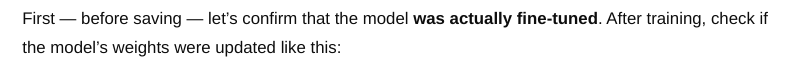

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} - {param.sum().item()}")

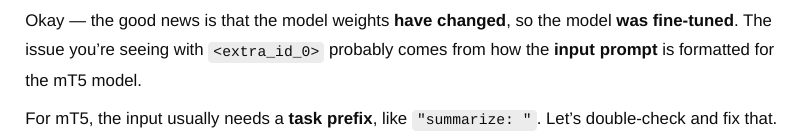

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_path = "./mt5-finetuned"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

# Properly formatted input with task prefix
simple_text = "summarize: This is a simple insurance policy."
inputs = tokenizer(simple_text, return_tensors="pt", padding=True, truncation=True, max_length=512)

# Generate summary
output = model.generate(**inputs)
summary = tokenizer.decode(output[0], skip_special_tokens=True)

print(summary)

<extra_id_0>


In [ ]:
output = model.generate(**inputs, max_length=100, num_beams=5, early_stopping=True)
summary = tokenizer.decode(output[0], skip_special_tokens=True)

print(summary)

<extra_id_0>


# **So mT5 Not Working Properly So again try mBART**

In [ ]:
!ls /content/mbart-finetuned

config.json		model.safetensors	 special_tokens_map.json  tokenizer_config.json
generation_config.json	sentencepiece.bpe.model  spiece.model


In [ ]:
import os
model_name = "/content/mbart-finetuned"
print(os.listdir(model_name))

['sentencepiece.bpe.model', 'model.safetensors', 'special_tokens_map.json', 'tokenizer_config.json', 'spiece.model', 'config.json', 'generation_config.json']


In [ ]:
tokenizer = MBartTokenizer(vocab_file=f"{model_name}/spiece.model", src_lang="en_XX")

In [ ]:
with open(f"{model_name}/spiece.model", "rb") as f:
    content = f.read(100)
    print(content[:10])  # Just to confirm it’s opening

b'\n\x0e\n\x05<pad>\x15'


In [ ]:
print(tokenizer.special_tokens_map)
print(tokenizer.vocab_size)

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>', 'additional_special_tokens': ['ar_AR', 'cs_CZ', 'de_DE', 'en_XX', 'es_XX', 'et_EE', 'fi_FI', 'fr_XX', 'gu_IN', 'hi_IN', 'it_IT', 'ja_XX', 'kk_KZ', 'ko_KR', 'lt_LT', 'lv_LV', 'my_MM', 'ne_NP', 'nl_XX', 'ro_RO', 'ru_RU', 'si_LK', 'tr_TR', 'vi_VN', 'zh_CN']}
250127


In [ ]:
from safetensors.torch import safe_open

model_path = f"{model_name}/model.safetensors"

with safe_open(model_path, framework="pt", device="cpu") as f:
    print(f.keys())

['final_logits_bias', 'model.decoder.embed_positions.weight', 'model.decoder.layer_norm.bias', 'model.decoder.layer_norm.weight', 'model.decoder.layernorm_embedding.bias', 'model.decoder.layernorm_embedding.weight', 'model.decoder.layers.0.encoder_attn.k_proj.bias', 'model.decoder.layers.0.encoder_attn.k_proj.weight', 'model.decoder.layers.0.encoder_attn.out_proj.bias', 'model.decoder.layers.0.encoder_attn.out_proj.weight', 'model.decoder.layers.0.encoder_attn.q_proj.bias', 'model.decoder.layers.0.encoder_attn.q_proj.weight', 'model.decoder.layers.0.encoder_attn.v_proj.bias', 'model.decoder.layers.0.encoder_attn.v_proj.weight', 'model.decoder.layers.0.encoder_attn_layer_norm.bias', 'model.decoder.layers.0.encoder_attn_layer_norm.weight', 'model.decoder.layers.0.fc1.bias', 'model.decoder.layers.0.fc1.weight', 'model.decoder.layers.0.fc2.bias', 'model.decoder.layers.0.fc2.weight', 'model.decoder.layers.0.final_layer_norm.bias', 'model.decoder.layers.0.final_layer_norm.weight', 'model.dec

In [ ]:
import os

model_path = f"{model_name}/model.safetensors"
print(f"File exists: {os.path.exists(model_path)}")
print(f"File size: {os.path.getsize(model_path) / (1024 * 1024):.2f} MB")

File exists: True
File size: 2331.23 MB


In [ ]:
from safetensors.torch import load_file

state_dict = load_file(model_path)
print(f"Number of keys: {len(state_dict)}")
print(f"First few keys: {list(state_dict.keys())[:5]}")
print(f"Shape of one weight: {state_dict[list(state_dict.keys())[0]].shape}")

Number of keys: 516
First few keys: ['final_logits_bias', 'model.decoder.embed_positions.weight', 'model.decoder.layer_norm.bias', 'model.decoder.layer_norm.weight', 'model.decoder.layernorm_embedding.bias']
Shape of one weight: torch.Size([1, 250027])


In [ ]:
from transformers import MBartForConditionalGeneration, MBartConfig

# Load the config from the original model
config = MBartConfig.from_pretrained(model_name)
print(config)

MBartConfig {
  "_name_or_path": "facebook/mbart-large-cc25",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "MBartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "forced_eos_token_id": 2,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_length": null,
  "max_position_embeddings": 1024,
  "model_type": "mbart",
  "normalize_before": true,
  "nor

In [ ]:
missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

Missing keys: ['shared.weight', 'encoder.embed_tokens.weight', 'encoder.block.0.layer.0.SelfAttention.q.weight', 'encoder.block.0.layer.0.SelfAttention.k.weight', 'encoder.block.0.layer.0.SelfAttention.v.weight', 'encoder.block.0.layer.0.SelfAttention.o.weight', 'encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight', 'encoder.block.0.layer.0.layer_norm.weight', 'encoder.block.0.layer.1.DenseReluDense.wi_0.weight', 'encoder.block.0.layer.1.DenseReluDense.wi_1.weight', 'encoder.block.0.layer.1.DenseReluDense.wo.weight', 'encoder.block.0.layer.1.layer_norm.weight', 'encoder.block.1.layer.0.SelfAttention.q.weight', 'encoder.block.1.layer.0.SelfAttention.k.weight', 'encoder.block.1.layer.0.SelfAttention.v.weight', 'encoder.block.1.layer.0.SelfAttention.o.weight', 'encoder.block.1.layer.0.layer_norm.weight', 'encoder.block.1.layer.1.DenseReluDense.wi_0.weight', 'encoder.block.1.layer.1.DenseReluDense.wi_1.weight', 'encoder.block.1.layer.1.DenseReluDense.wo.weight', 'encoder.b

In [ ]:
model = MBartForConditionalGeneration(config)
model.load_state_dict(state_dict, strict=False)

_IncompatibleKeys(missing_keys=['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'], unexpected_keys=[])

In [12]:
model_name = "/content/mbart-finetuned"

In [1]:
from transformers import MBartForConditionalGeneration, MBartTokenizer

model_name = "/content/mbart-finetuned"

# Load config and tokenizer
try:
    tokenizer = MBartTokenizer.from_pretrained(model_name)
    print("Tokenizer loaded successfully")
except Exception as e:
    print(f"Error loading tokenizer: {e}")

try:
    model = MBartForConditionalGeneration.from_pretrained(
        model_name,
        state_dict=state_dict
    )
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'T5Tokenizer'. 
The class this function is called from is 'MBartTokenizer'.


Error loading tokenizer: Unable to load vocabulary from file. Please check that the provided vocabulary is accessible and not corrupted.
Error loading model: name 'state_dict' is not defined


In [2]:
import os

model_name = "/content/mbart-finetuned"
print(os.listdir(model_name))


['spiece.model', 'generation_config.json', 'special_tokens_map.json', 'model.safetensors', 'tokenizer_config.json', 'config.json']


In [3]:
from transformers import MBartForConditionalGeneration, MBartTokenizer

model_name = "/content/mbart-finetuned"

# Load the original mBART tokenizer and model
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-cc25")
tokenizer = MBartTokenizer.from_pretrained("facebook/mbart-large-cc25")

# Save the correct mBART tokenizer and config
model.save_pretrained(model_name)
tokenizer.save_pretrained(model_name)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:2758: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1024, 'num_beams': 5}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('/content/mbart-finetuned/tokenizer_config.json',
 '/content/mbart-finetuned/special_tokens_map.json',
 '/content/mbart-finetuned/sentencepiece.bpe.model',
 '/content/mbart-finetuned/added_tokens.json')

In [4]:
from safetensors.torch import load_file
state_dict = load_file(f"{model_name}/model.safetensors")

model = MBartForConditionalGeneration.from_pretrained(
    model_name,
    state_dict=state_dict
)

print("Model loaded successfully!")

Model loaded successfully!


In [5]:
from transformers import MBartForConditionalGeneration, MBartTokenizer

model_name = "/content/mbart-finetuned"

# Load the model and tokenizer
model = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer = MBartTokenizer.from_pretrained(model_name)

# Example input text
input_text = "This policy covers damage to your vehicle caused by accidents"

# Tokenize and prepare input
inputs = tokenizer(input_text, return_tensors="pt")

# Generate prediction
outputs = model.generate(**inputs, max_length=100, num_beams=5, early_stopping=True)

# Decode the generated output
predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Predicted text:", predicted_text)


Predicted text: policy cover cover cover cover cover cover covers damage to policy covers damage to policy covers damage to covers damage to covers damage to covers damage to damage to your vehicle caused by accidents


# **Using this to Avoid Repeativity**

In [ ]:
# outputs = model.generate(
#     **inputs,
#     max_length=100,
#     num_beams=5,
#     early_stopping=True,
#     no_repeat_ngram_size=3,
#     length_penalty=2.0
# )

In [6]:
input_text = "Life insurance provides financial security for beneficiaries"

# mBART uses language tokens, e.g., for English
inputs = tokenizer(input_text, return_tensors="pt", src_lang="en_XX")

# Generate prediction
outputs = model.generate(**inputs, max_length=100, num_beams=5, early_stopping=True,no_repeat_ngram_size=3,length_penalty=2.0,repetition_penalty=1.5,num_return_sequences=1,top_p=0.9,temperature=0.7)

# Decode the generated output
predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Predicted text:", predicted_text)


Keyword arguments {'src_lang': 'en_XX'} not recognized.
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Predicted text: insurance provides insurance provides financial insurance provides--- insurance provides. insurance provides security provides financial security providing financial security security security--protecting-insurances--security security security and financial security for beneficiaries


In [ ]:
#####################################################################################################

# **Streamlit**

In [7]:
!pip install -q streamlit
!pip install -q localtunnel
!pip install -q pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement localtunnel (from versions: none)
ERROR: No matching distribution found for localtunnel


In [ ]:
%%writefile app1.py

In [ ]:
# %%writefile app1.py
# import streamlit as st
# from transformers import MBartForConditionalGeneration, MBartTokenizer

# # Model directory
# model_name = "/content/mbart-finetuned"

# # Load the model and tokenizer
# model = MBartForConditionalGeneration.from_pretrained(model_name)
# tokenizer = MBartTokenizer.from_pretrained(model_name)

# # Streamlit app title
# st.title("Insurance Policy Summarizer")

# # Text input for user
# input_text = st.text_area("Enter policy description:", "Life insurance provides financial security for beneficiaries")

# if st.button("Summarize"):
#     if input_text.strip():
#         # Tokenize and prepare input
#         inputs = tokenizer(input_text, return_tensors="pt", src_lang="en_XX")

#         # Generate prediction
#         outputs = model.generate(**inputs, max_length=100, num_beams=5, early_stopping=True,no_repeat_ngram_size=3,length_penalty=2.0,repetition_penalty=1.5,num_return_sequences=1,top_p=0.9,temperature=0.7)

#         # Decode the generated output
#         predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

#         st.subheader("Summarized Policy:")
#         st.write(predicted_text)
#     else:
#         st.warning("Please enter some text to summarize.")


Overwriting app1.py


In [8]:
%%writefile app1.py

import streamlit as st
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

# Load the mBART model and tokenizer
@st.cache_resource()
def load_model():
    model_name = "facebook/mbart-large-50"
    tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
    model = MBartForConditionalGeneration.from_pretrained(model_name)
    return model, tokenizer

model, tokenizer = load_model()

# Streamlit UI
st.title("Text Summarization with Facebook's mBART")

text = st.text_area("Enter the text you want to summarize:")

if st.button("Summarize"):
    if text:
        # Tokenize input text
        inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)

        # Generate summary
        summary_ids = model.generate(**inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)

        # Decode and display summary
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        st.subheader("Summary:")
        st.write(summary)
    else:
        st.warning("Please enter some text to summarize!")



Writing app1.py


In [9]:
from pyngrok import ngrok

# Replace 'YOUR_AUTHTOKEN' with your actual ngrok authtoken
ngrok.set_auth_token("2t49imFFYgswbiILhxmRavW6AlI_5a5SfwjpV9f29CtGGGYiu")

# Run the Streamlit app in the background
!streamlit run app1.py &>/dev/null&

# Create a public URL using ngrok
try:
    public_url = ngrok.connect(8501)
    print(f"Streamlit app is running at {public_url}")
except Exception as e:
    print(f"Error: {e}")
    print("Trying to run with localtunnel")
    !streamlit run app1.py &>/content/logs.txt & npx localtunnel --port 8501

Streamlit app is running at NgrokTunnel: "https://b26c-34-82-183-75.ngrok-free.app" -> "http://localhost:8501"
